In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import torch
from torch.autograd import Variable

from generation.config import CHECKPOINT_DIR

In [2]:
# WANDB_ID = "2gy2j50c"
WANDB_ID = "1ner3t5a"

config = {
    "detector": 0,
    "lr": 1e-5,
    "epochs_num": 5000,
    "batch_size": 64,
    "log_each": 1,
    "save_each": 2,
    "device": "cuda:1",
    "x_dim": 1024,
    "z_dim": 8,
    "disc_coef": 10,
    "lambda": 10
}

In [3]:
from generation.dataset.shapes_dataset import ShapesDataset

dataset = ShapesDataset(config['detector'], signal_dim=config['x_dim'])
origin_noises = dataset.noises

/datadrive/pafakanov/hse/hep_generative_models/generation/dataset/shapes_dataset.py:54: RuntimeWarning: invalid value encountered in true_divide
  data = (data - min_values[:, None]) / (max_values - min_values)[:, None]


In [4]:
checkpoint_dir = os.path.join(CHECKPOINT_DIR, WANDB_ID)
checkpoint_paths = [os.path.join(checkpoint_dir, name) \
         for name in os.listdir(checkpoint_dir)]
checkpoint_paths.sort(key=os.path.getctime, reverse=True)
generator_checkpoint_paths = [path for path in checkpoint_paths \
                if os.path.basename(path).startswith("generator")]
discriminator_checkpoint_paths = [path for path in checkpoint_paths \
                if os.path.basename(path).startswith("discriminator")]

In [5]:
from generation.nets.shapes import Generator, Discriminator


generator = Generator(config)
discriminator = Discriminator(config)

In [6]:
discriminator.load_state_dict(torch.load(discriminator_checkpoint_paths[0]))

<All keys matched successfully>

In [7]:
def load_net(path):
    generator = Generator(config)
    generator.load_state_dict(torch.load(path))
    return generator


def average_snapshots(list_of_snapshots_paths):
    snapshots_weights = {}

    for snapshot_path in list_of_snapshots_paths:
        model = load_net(path=snapshot_path)
        snapshots_weights[snapshot_path] = dict(model.named_parameters())

    params = model.named_parameters()
    dict_params = dict(params)

    N = len(snapshots_weights)

    for name in dict_params.keys():
        custom_params = None
        for _, snapshot_params in snapshots_weights.items():
            if custom_params is None:
                custom_params = snapshot_params[name].data
            else:
                custom_params += snapshot_params[name].data
        dict_params[name].data.copy_(custom_params/N)

    model_dict = model.state_dict()
    model_dict.update(dict_params)

    model.load_state_dict(model_dict)
    model.eval()

    return model


def generate_noises(generator, num=500):
    z = Variable(torch.rand(num, config['z_dim']))
    generated_noises = generator(z).detach().numpy()
    return generated_noises

In [8]:
def clip_values(origin, generated):
    min_signal = np.min(origin, axis=0)
    max_signal = np.max(origin, axis=0)

    min_mask = generated < min_signal
    max_mask = generated > max_signal

    min_matrix = np.repeat([min_signal], len(generated), axis=0)
    max_matrix = np.repeat([max_signal], len(generated), axis=0) 
    
    generated[min_mask] = min_matrix[min_mask]
    generated[max_mask] = max_matrix[max_mask]

    return generated


def compare_results(generator):
    origin_noises = dataset.noises
    generated_noises = generate_noises(generator)
    generated_noises = clip_values(origin_noises, generated_noises)
    f, ax = plt.subplots(1, 2, figsize=(12, 5))
    f.suptitle("Scaled noises", fontsize=15, weight='bold')
    ax[0].set_title("Generated")
    ax[1].set_title("Origin")
    idxs = np.random.choice(range(len(origin_noises)), len(generated_noises))
    for i in range(len(generated_noises)):
        ax[0].plot(generated_noises[i])
        ax[1].plot(origin_noises[idxs[i]])
    plt.show()
        
    generated_noises = dataset.scaler.inverse_transform(generated_noises)
    origin_noises = dataset.scaler.inverse_transform(dataset.noises)
    generated_noises = clip_values(origin_noises, generated_noises)
    f, ax = plt.subplots(1, 2, figsize=(12, 5))
    f.suptitle("Origin noises", fontsize=15, weight='bold')
    ax[0].set_title("Generated")
    ax[1].set_title("Origin")
    for i in range(len(generated_noises)):
        ax[0].plot(generated_noises[i])
        ax[1].plot(origin_noises[idxs[i]])
    plt.show()
        
    origin_signals = dataset.signals
    generated_signals = generated_noises + np.mean(dataset.signals, axis=0)
    generated_signals = clip_values(origin_signals, generated_signals)
    f, ax = plt.subplots(1, 2, figsize=(12, 5))
    f.suptitle("Origin signals", fontsize=15, weight='bold')
    ax[0].set_title("Generated")
    ax[1].set_title("Origin")
    for i in range(len(generated_signals)):
        idx = np.random.choice(range(len(origin_signals)))
        ax[0].plot(generated_signals[i])
        ax[1].plot(origin_signals[idxs[i]])
    plt.show()
    
    return generated_signals

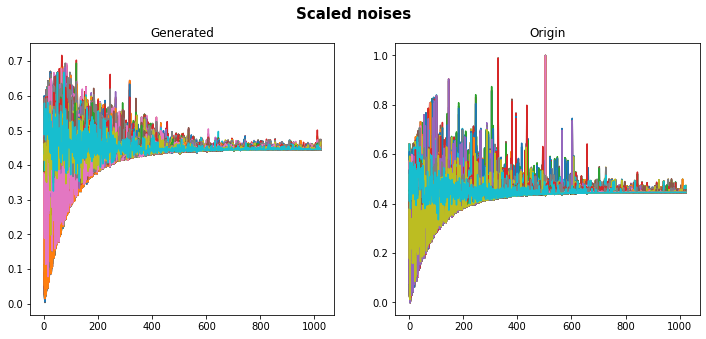

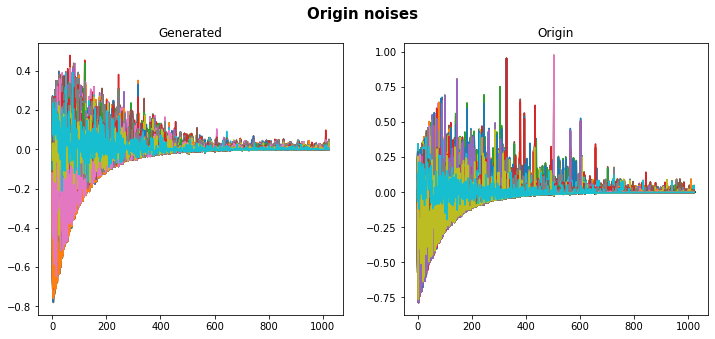

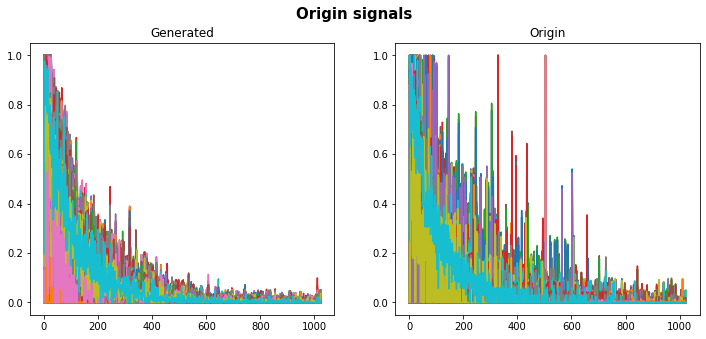

In [9]:
generator = average_snapshots(generator_checkpoint_paths[:1])
generated_signals = compare_results(generator)

In [10]:
idxs = np.random.choice(range(len(dataset.signals)), len(generated_signals))
origin_signals = dataset.signals[idxs]

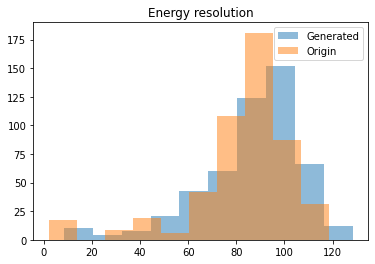

In [11]:
plt.title("Energy resolution")
plt.hist(np.sum(generated_signals, axis=1), alpha=0.5)
plt.hist(np.sum(origin_signals, axis=1), alpha=0.5)
plt.legend(['Generated', 'Origin'])
plt.show()

In [13]:
import multiprocessing as mp

from generation.dataset.data_utils import postprocess_signal


def get_baseline_prediction(signal):
    half_amplitude = np.min(signal) + (np.max(signal) - np.min(signal)) / 2
    prev = signal[0]
    for idx, item in enumerate(signal):
        if item > half_amplitude:
            return idx
         

with mp.Pool(32) as pool:
    post_generated_signals = list(tqdm.tqdm(pool.imap(postprocess_signal, \
                                            generated_signals)))
    post_origin_signals = list(tqdm.tqdm(pool.imap(postprocess_signal, \
                                            origin_signals)))

500it [04:00,  2.08it/s]
500it [03:51,  2.16it/s]


In [14]:
generated_predictions = [get_baseline_prediction(signal) \
                         for signal in post_generated_signals]
origin_predictions = [get_baseline_prediction(signal) \
                         for signal in post_origin_signals]

(array([  0.,   8., 392.,  84.,   5.,   2.,   3.,   0.,   0.,   1.,   2.,
          1.,   1.,   0.,   0.,   0.,   0.]),
 array([ 70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130,
        135, 140, 145, 150, 155]),
 <a list of 17 Patch objects>)

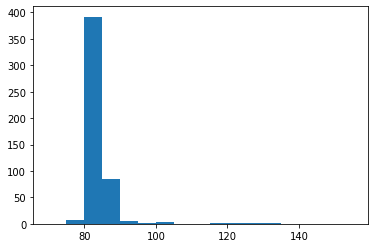

In [20]:
plt.hist(generated_predictions, bins = np.arange(70, 160, 5))

In [18]:
np.min(generated_predictions)

77

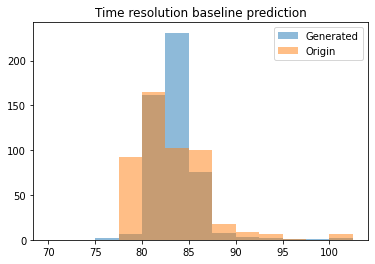

In [24]:
plt.title("Time resolution baseline prediction")
plt.hist(generated_predictions, bins = np.arange(70, 105, 2.5), alpha=0.5)
plt.hist(origin_predictions, bins = np.arange(70, 105, 2.5), alpha=0.5)
plt.legend(['Generated', 'Origin'])
plt.show()

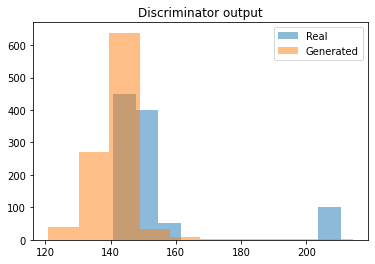

In [32]:
d_real = discriminator(torch.from_numpy(origin_noises[:len(z)]).float())
d_fake = discriminator(generator(z))

d_real = d_real.detach().numpy().flatten()
d_fake = d_fake.detach().numpy().flatten()

plt.title("Discriminator output")
plt.hist(d_real, alpha=0.5)
plt.hist(d_fake, alpha=0.5)
plt.legend(['Real', 'Generated'])
plt.show()